In [83]:
# importing dependencies
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize,sent_tokenize
import string
import operator
import math
import string
from matplotlib import pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import Birch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pikepdf

%matplotlib inline

In [84]:
def viz_clusters(X, labels):
    """
    Takes in the datapoints and the cluster labels and then construcs a scatterplot indicatiing  each custer 
    """
    X = np.array(X)
    plt.scatter(X[:,1], X[:,0], c=labels)
    plt.show()
    
def viz_clusters_after(X, labels):
    labels =list(set(X))
    plt.plot(X[:,1], X[:,0], c=labels)
    
def draw_table(norm_X,mean,closest):
    count = 0
    sentences = []
    for i in range(len(mean)):
        sentences_with_label = [sent[1] for sent in norm_X if sent[0] == mean[i][0]]
        for sent in sentences_with_label:
            sentence_row = (count,sent,mean[i][0],mean[i][1],closest[i][1])
            sentences.append(sentence_row)
            count +=1
    return np.array(sentences)

In [85]:
def set_threshold(sentences):
    return int(0.5 * len(sentences))


In [86]:
# 1.0  SENTENCE PREPROCESSING
def preprocess(words):
    stp = stopwords.words('english')
    white_list = ['Allah', 'God']
    words = [word.lower() for word in words]
    words = [lemmatize(word) for word in words]
    words = [word for word in words if word not in stp]
    words = [word for word in words if word not in string.punctuation]
    return words

def lemmatize(word):
    wnl = WordNetLemmatizer()
    lemmed = wnl.lemmatize(word)
    return lemmed

def tagger(sentence):
    """
    takes a whole sentence as input and gets the Part-Of-Speech tag for each word in the sentence
    """
    acceptable_words = []
    word_tags = pos_tag(sentence)
    print(word_tags)
    for word_tag in word_tags:
        if (word_tag[1] == "NP" or word_tag[1] == "VP"):
            acceptable_words.append(word_tag[0])
    return acceptable_words


In [87]:
# 2.0 CLUSTERING
def vectorize(document):
    words = word_tokenize(document)
    words = preprocess(words)
    X = [TaggedDocument(word,[idnx]) for idnx,word in enumerate(words)]
    vectorizer = Doc2Vec(X, size=10)
    sentence_vectors = [vectorizer.infer_vector(word_tokenize(sen), alpha=2,steps=400) for sen in sent_tokenize(document)]
    return sentence_vectors

def determine_th(document):
    no_sen = len(sent_tokenize(document)) # the number of sentences in the document
    if(no_sen <=50):
        return 0.3
    if(no_sen > 50 and no_sen <= 100):
        return 0.5
    if(n0_sen > 100  and no_sen <= 150):
        return 0.7
    if(no_sen > 150):
        return 0.9
    
def calculate_mean(X):
    clusters = set([sent[0] for sent in X ])
    cluster_mean = []
    for cluster in clusters:
        cluster_value = 0
        count = 0
        for i,element in enumerate(X):
            if (cluster == element[0]):
                cluster_value += element[1]
                count += 1
        mean_cluster_value = cluster_value/count
        cluster_mean.append([cluster,mean_cluster_value])
    print("Cluster Means:")
    print(cluster_mean)
    return cluster_mean

def find_minimum_from_mean(cluster_means, vectorized):
    """
    This function computes the minimal distance between each element in X and the elements in Y
    cluster_means : A 2D array
    points : A 2D array consisting of cluster type and the corresponding value

    It returns an array which consist of point in X and the corresponding point in Y with the smallest distance the point in X

    """
    minimal_distances = []
    for clm in cluster_means:
        points_in_cluster = [v[1] for v in vectorized if v[0] == clm[0]]
        minimal = points_in_cluster[0]
        for pt in points_in_cluster:
            diff_current = abs(clm[1] - pt) 
            diff_minimal = clm[1] - minimal
            if (diff_current < diff_minimal):
                  minimal = pt
        minimal_distances.append((clm[0],minimal))
    print("Minimal", minimal_distances)
    return minimal_distances

def normalize_vector(v, labels):
    vectorized = []
    for i in range(len(v)):
        mean = abs(sum(v[i]/len(v[i])))
        vectorized.append((labels[i],mean))
    return vectorized

def vectors_to_sentences(clustered_sentences, sentence_vector, sentences):
    index = 0
    selected_sentences = []
    top_sentences = [s[1] for s in clustered_sentences ]
    for v in sentence_vector:
        if v[1] in top_sentences:
            print(v[1])
            selected_sentences.append((index,sentences[index]))
        index +=1
    return selected_sentences



In [88]:
def cluster_sentences(document):
    X = vectorize(document)
    th = determine_th(document)
    bcl = Birch(branching_factor=10, n_clusters=None, threshold=th).fit(X) # the algorithm figures out the clusters
    clusters = bcl.predict(X)
    labels = bcl.labels_
    norm_X = normalize_vector(X, labels)
    viz_clusters(norm_X,labels) # visualization before finding the mean
    cluster_means = calculate_mean(norm_X)
    cluster_sentences = find_minimum_from_mean(cluster_means, norm_X)
#     viz_clusters_after(cluster_sentences, set(labels)) # visualization after finding the closest to mean
    sents = vectors_to_sentences(cluster_sentences, norm_X, sent_tokenize(document))
    sentence_data = draw_table(norm_X,cluster_means,cluster_sentences)
    sentence_data = pd.DataFrame(sentence_data, columns = ['Sentence', 'Vector_Value', ' Cluster_ID', 'Cluster_Mean', 'Closest_Sentence_Vector'])
    return sents, sentence_data



In [89]:
# SUMMARIZE DOCUMENT 
def summarizeDocument(document):
    """
    functions takes a document and returns its summary
    """
    sentences = sent_tokenize(document)
    threshold = set_threshold(sent_tokenize(document))  
    indexed_sentences, sentence_data = cluster_sentences(document) 
    summary = [sent[1] for sent in indexed_sentences]
    return summary, sentence_data


/home/developer/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


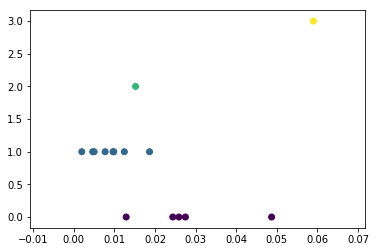

Cluster Means:
[[0, 0.027878005430102347], [1, 0.008751623741773074], [2, 0.01522156409919262], [3, 0.05900698900222778]]
Minimal [(0, 0.0487155057489872), (1, 0.018661629619600717), (2, 0.01522156409919262), (3, 0.05900698900222778)]
0.0487155057489872
0.018661629619600717
0.01522156409919262
0.05900698900222778
['Manually creating summaries can be a time-consuming activity.', 'When the volume of documents to be summarized becomes much, it becomes cumbersome to summarize these manually.', 'It also aims at producing summaries that covers the main ideas expressed in a passage.', 'Since documents are usually structured in such a way that different ideas are expressed at different sections (Rananavare & Reddy, 2017), the proposed system utilizes text clustering as a technique to handle this information spread as well reducing redundancy in the produced summaries by clustering sentences that most alike together and then picking a representative sentence from each cluster.']


,Sentence,Vector_Value,Cluster_ID,Cluster_Mean,Closest_Sentence_Vector
0,0.0,0.048716,0.0,0.027878,0.048716
1,1.0,0.025898,0.0,0.027878,0.048716
2,2.0,0.027486,0.0,0.027878,0.048716
3,3.0,0.024390,0.0,0.027878,0.048716
4,4.0,0.012901,0.0,0.027878,0.048716
5,5.0,0.018662,1.0,0.008752,0.018662
6,6.0,0.004668,1.0,0.008752,0.018662
7,7.0,0.005015,1.0,0.008752,0.018662
8,8.0,0.012452,1.0,0.008752,0.018662
9,9.0,0.009845,1.0,0.008752,0.018662


In [99]:
document = open('./raw_text/test__3.txt').read()
summary,sentence_data = summarizeDocument(document)
print(summary)
sentence_data

In [100]:
def summary_stats(doc,summary):
    summ_stats = """
    No of Sentences : {no_sen}
    No of Words : {no_words}
    No of Characters : {no_char}
    compression rate : {c_rate}%
    """.format(no_sen = len(sent_tokenize(summary)), no_words = len(word_tokenize(summary)), no_char = len(summary), c_rate = (len(summary)/len(document) * 100 ))
    return summ_stats

In [105]:
result = open('./raw_text/summaries/by-sumryx/summary2.txt','w+')
summary_text = " ".join(summary) 
result.write(summary_text)
summary_stats(document, summary_text)


'\n    No of Sentences : 4\n    No of Words : 108\n    No of Characters : 656\n    compression rate : 27.903019991492982%\n    '

In [102]:
len(sent_tokenize(document))

15

In [103]:
len(word_tokenize(document))

377

In [104]:
len(document)

2351